In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple

In [3]:
def plot_comparision3(
    im0: np.array,
    im1: np.array,
    im2: np.array,
    titles: Tuple[str, str, str] = ('', '', '')) -> None:
    """
    Plota um subplot com as três imagens informadas. O parâmetro
    de títulos é opcional.
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(im0, cmap='gray')
    axs[0].set_title(titles[0])
    axs[1].imshow(im1, cmap='gray')
    axs[1].set_title(titles[1])
    axs[2].imshow(im2, cmap='gray')
    axs[2].set_title(titles[2])
    plt.show()

def plot_comparision2(
    im0: np.array,
    im1: np.array,
    titles: Tuple[str, str] = ('', '')) -> None:
    """
    Plota um subplot com as duas imagens informadas. O parâmetro
    de títulos é opcional.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(im0, cmap='gray')
    axs[0].set_title(titles[0])
    axs[1].imshow(im1, cmap='gray')
    axs[1].set_title(titles[1])
    plt.show()


def get_mean_filter(order: int) -> np.array:
    """
    Retorna um filtro de média
    """
    return np.ones(shape=(order, order)) * (1/order**2)



def convolution(image: np.array, mask: np.array) -> np.array:
    """
    Aplica a convolução na imagem utilizando a máscara informada.
    """
    # Rotaciona a máscara em 180 graus
    mask = np.flipud(np.fliplr(mask))

    # Pega a ordem da máscara
    order = mask.shape[0]
    half_order = order//2

    # Calcula a imagem resultante
    result = np.zeros(shape=(image.shape))
    image = np.pad(image, half_order)
    M, N = image.shape

    for i in range(0, M - order):
        for j in range(0, N - order):
            result[i, j] = (mask * image[i:i+order, j:j+order]).sum()

    return result


def convolution_median_filter(image: np.array, order: int) -> np.array:
    """
    Aplica a máscara de mediana pela convolução.
    """
    result = np.zeros(shape=(image.shape))
    M, N = image.shape

    for i in range(0, M - order):
        for j in range(0, N - order):
            result[i, j] = np.median(image[i:i+order, j:j+order].flatten())

    return result


def get_butterworth_filter(shape: Tuple[int, int], diameter: int, order: int = 2) -> np.array:
    """
    Retorna um filtro de Butterworth com o diâmetro
    e ordem informadoss.
    """
    y = np.arange(-shape[0], shape[0], 1)
    x = np.arange(-shape[1], shape[1], 1)

    u, v = np.meshgrid(x, y)
    D = np.sqrt(u**2 + v**2)

    return 1 / (1 + (D/diameter)**(2*order))


def image_mse(im0: np.array, im1: np.array) -> float:
    """
    Calcula o erro quadrático médio entre as duas imagens.
    """
    N, M = im0.shape
    return ((im0 - im1)**2).flatten().sum() / (N * M)


def psrn(im0: np.array, im1: np.array) -> float:
    """
    Calcula o 'peak signal to noise ratio' entre as duas imagens
    informadas.
    """
    return 10 * np.log10(255**2 / image_mse(im0, im1))


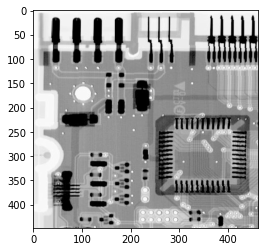

In [11]:
original = plt.imread('../images/original.tif')[:, :, 0].astype('uint8')
plt.imshow(original, cmap='gray')
plt.show()

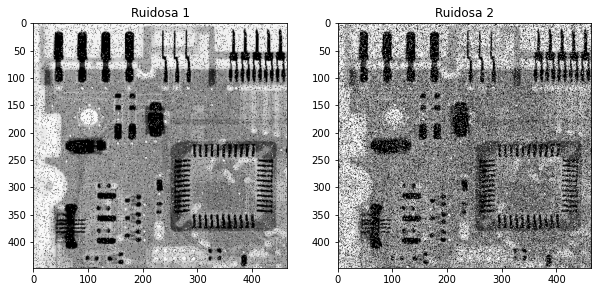

In [12]:
ruidosa1 = plt.imread('../images/ruidosa1.tif').astype('uint8')
ruidosa2 = plt.imread('../images/ruidosa2.tif').astype('uint8')
plot_comparision2(ruidosa1, ruidosa2, ('Ruidosa 1', 'Ruidosa 2'))

In [13]:
results = []

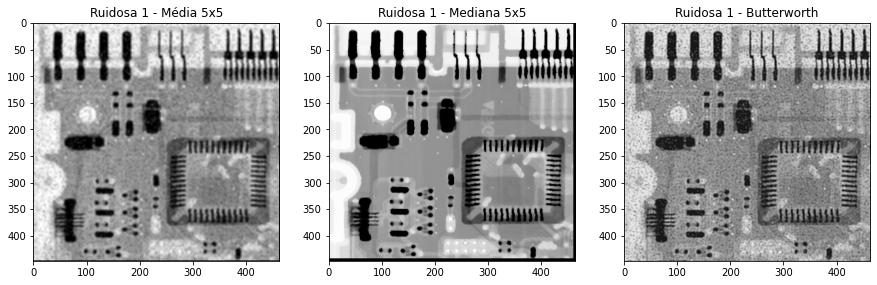

In [14]:
ruidosa1_mean = convolution(ruidosa1, get_mean_filter(5))
ruidosa1_median = convolution_median_filter(ruidosa1, 5)

H_butter = get_butterworth_filter(ruidosa1.shape, 200, 4)

im_fill = np.zeros((2*ruidosa1.shape[0], 2*ruidosa1.shape[1]))
im_fill[0:ruidosa1.shape[0], 0:ruidosa1.shape[1]] = ruidosa1
F_shift = np.fft.fftshift(np.fft.fft2(im_fill))

G_butter = F_shift * H_butter
im_gauss_fill = np.real(np.fft.ifft2(np.fft.fftshift(G_butter))) 
ruidosa1_butterworth = im_gauss_fill[0:ruidosa1.shape[0], 0:ruidosa1.shape[1]]

plot_comparision3(
    ruidosa1_mean, ruidosa1_median, ruidosa1_butterworth,
    ('Ruidosa 1 - Média 5x5', 'Ruidosa 1 - Mediana 5x5', 'Ruidosa 1 - Butterworth'))

results.append([
    psrn(original, ruidosa1_mean),
    psrn(original, ruidosa1_median),
    psrn(original, ruidosa1_butterworth),
])

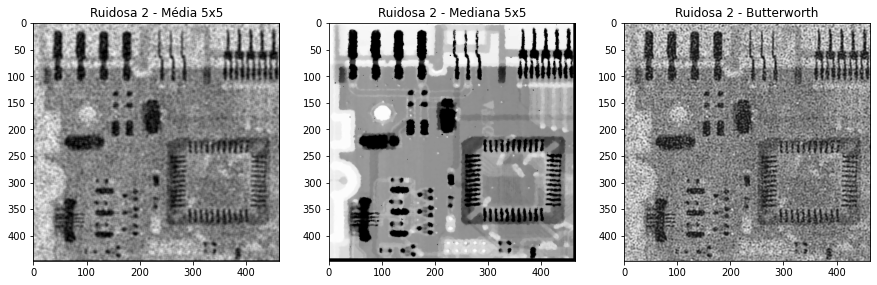

In [15]:
#
ruidosa2_mean = convolution(ruidosa2, get_mean_filter(5))
ruidosa2_median = convolution_median_filter(ruidosa2, 5)

H_butter = get_butterworth_filter(ruidosa2.shape, 200, 4)

im_fill = np.zeros((2*ruidosa2.shape[0], 2*ruidosa2.shape[1]))
im_fill[0:ruidosa2.shape[0], 0:ruidosa2.shape[1]] = ruidosa2
F_shift = np.fft.fftshift(np.fft.fft2(im_fill))

H_butter = F_shift * H_butter
im_gauss_fill = np.real(np.fft.ifft2(np.fft.fftshift(H_butter))) 
ruidosa2_butterworth = im_gauss_fill[0:ruidosa2.shape[0], 0:ruidosa2.shape[1]]

plot_comparision3(
    ruidosa2_mean, ruidosa2_median, ruidosa2_butterworth,
    ('Ruidosa 2 - Média 5x5', 'Ruidosa 2 - Mediana 5x5', 'Ruidosa 2 - Butterworth'))

results.append([
    psrn(original, ruidosa2_mean),
    psrn(original, ruidosa2_median),
    psrn(original, ruidosa2_butterworth),
])

In [18]:
df = pd.DataFrame(results, columns=['Mean', 'Median', 'Butterworth'])

In [19]:
df.index = ['Ruidosa 1', 'Ruidosa 2']
df

,Mean,Median,Butterworth
Ruidosa 1,19.362094,14.606718,21.038770
Ruidosa 2,15.717835,14.444589,15.584805


Observa-se que ambas imagens ruidosas estavam bem deterioradas em relação a imagem original. Ainda que os filtros de média e butterworth tenham desempenhando bem, removendo-se parte dos ruídos como podemos observar pelos valores da métrica PSNR, o filtro de mediana foi o que obteve os melhores resultados, conseguindo remover muito bem o ruído do tipo sal e pimenta.